In [2]:
import requests
import json

In [9]:
import pandas as pd

In [82]:
import seaborn as sb

sb.set(rc={'figure.figsize':(11,8)})

In [391]:
al_url = 'https://test-amp-model-api.covidamp.org/state_base_model/AL'

#al_url = 'http://127.0.0.1:8000/state_base_model/AL'
r_json = requests.get(al_url).json()

In [369]:
date_url = 'https://amp-model-api.covidamp.org/update_date'

date_json = requests.get(date_url).json()

In [370]:
date_json

{'last_data_update': '2020-07-20', 'last_policy_update': '2020-07-20'}

In [371]:
r_json.keys()

dict_keys(['modelrun', 'state', 'population', 'date', 'cases', 'deaths', 'counterfactual_cases', 'counterfactual_deaths', 'results', 'interventions'])

In [372]:
actuals_df = pd.DataFrame(json.loads(r_json['results'][2]['run']))

In [373]:
actuals_df.head()

,date,exposed,infected_a,infected_b,infected_c,recovered,dead,asymp,source,R effective,infected,pct_change,doubling_time
0,1584057600000,4.1250,4.1250,1.50,0.3750,0.0,0.0,1.23750,actuals,2.53,7.23750,NaN,NaN
1,1584144000000,8.2500,8.2500,3.00,0.7500,0.0,0.0,2.47500,actuals,2.53,14.47500,NaN,NaN
2,1584230400000,15.8125,15.8125,5.75,1.4375,0.0,0.0,4.74375,actuals,2.53,27.74375,NaN,NaN
3,1584316800000,19.9375,19.9375,7.25,1.8125,0.0,0.0,5.98125,actuals,2.53,34.98125,NaN,NaN
4,1584403200000,26.8125,26.8125,9.75,2.4375,0.0,0.0,8.04375,actuals,2.53,47.04375,NaN,NaN


In [392]:
cf_df = pd.DataFrame(json.loads(r_json['results'][0]['run']))

In [393]:
cf_df['date'] = pd.to_datetime(cf_df['date'], unit='ms')

In [394]:
cf_df.head()

,date,state,fips,cases,deaths,estimated_recovered,active,estimated_hospitalized,estimated_infected,exposed,...,infected_b,infected_c,recovered,dead,asymp,R effective,source,infected,pct_change,doubling_time
0,2020-03-13,Alabama,1.0,6.0,0.0,0.0,6.0,1.50,20.547945,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
1,2020-03-14,Alabama,1.0,12.0,0.0,0.0,12.0,3.00,41.095890,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
2,2020-03-15,Alabama,1.0,23.0,0.0,0.0,23.0,5.75,78.767123,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
3,2020-03-16,Alabama,1.0,29.0,0.0,0.0,29.0,7.25,99.315068,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN
4,2020-03-17,Alabama,1.0,39.0,0.0,0.0,39.0,9.75,133.561644,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN


In [395]:
cf_df_good = cf_df.loc[:, ['date', 'infected', 'dead', 'recovered', 'asymp']]

In [396]:
cf_df_good.tail()

,date,infected,dead,recovered,asymp
306,2021-01-13,113.594181,19928.981346,4.047245e+06,26.414434
307,2021-01-14,106.924797,19929.317657,4.047259e+06,24.860838
308,2021-01-15,100.646809,19929.634371,4.047272e+06,23.398670
309,2021-01-16,94.737265,19929.932623,4.047285e+06,22.022546
310,2021-01-17,89.174558,19930.213484,4.047296e+06,20.727397


In [397]:
cf_df_good['lagged_dead'] = cf_df_good['dead'].shift(-1 * (6+11+8))

In [398]:
cf_df_good['cum_infected'] = cf_df_good['recovered'] + cf_df_good['dead'] + cf_df_good['infected'] #- cf_df_good['asymp']

In [399]:
cf_df_good['cum_resolved'] = cf_df_good['recovered'] + cf_df_good['dead']

In [400]:
cf_df_good['cfr'] = cf_df_good['dead'] / cf_df_good['cum_infected']

In [401]:
cf_df_good['shifted_cfr'] = cf_df_good['lagged_dead'] / cf_df_good['cum_infected']

In [402]:
cf_df_good.head()

,date,infected,dead,recovered,asymp,lagged_dead,cum_infected,cum_resolved,cfr,shifted_cfr
0,2020-03-13,NaN,NaN,NaN,NaN,3.894534,NaN,NaN,NaN,NaN
1,2020-03-14,NaN,NaN,NaN,NaN,4.054637,NaN,NaN,NaN,NaN
2,2020-03-15,NaN,NaN,NaN,NaN,4.215322,NaN,NaN,NaN,NaN
3,2020-03-16,NaN,NaN,NaN,NaN,4.377523,NaN,NaN,NaN,NaN
4,2020-03-17,NaN,NaN,NaN,NaN,4.542184,NaN,NaN,NaN,NaN


Text(0.5, 1.0, 'CFR to date (dead over cum. infected) - shifted and not')

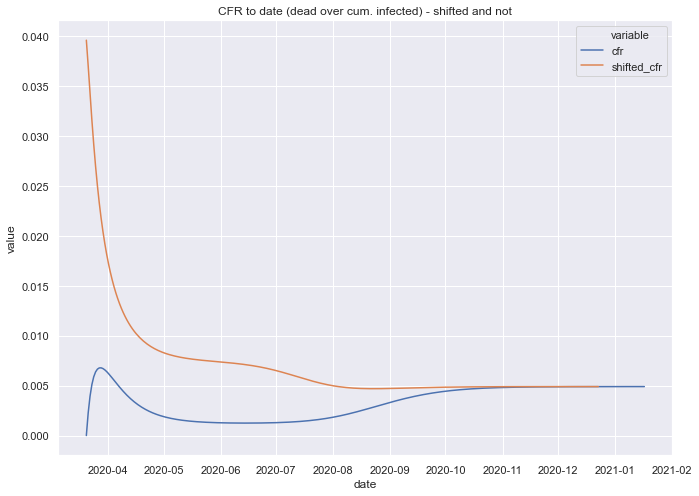

In [405]:
#ax = sb.lineplot(x="date", y="value", hue="variable", data=pd.melt(cf_df_good.loc[(cf_df_good['date'] > '2020-05-01'), ['date', 'cfr', 'shifted_cfr']], ['date']))
ax = sb.lineplot(x="date", y="value", hue="variable", data=pd.melt(cf_df_good.loc[:, ['date', 'cfr', 'shifted_cfr']], ['date']))
ax.set_title('CFR to date (dead over cum. infected) - shifted and not')

In [404]:
cf_df_good.loc[(cf_df_good['date'] == '2021-01-01'), 'cfr']

294    0.004898
Name: cfr, dtype: float64

In [388]:
0.009764 / 0.013999999999999999

0.6974285714285715

In [387]:
0.004883 / 0.006999999999999999

0.6975714285714286

In [363]:
percent_asymp = 0.3

hospitalization_rate = 0.10
hospitalized_cases_requiring_icu_care = 0.5
death_rate_for_critical = 0.4

# CFR is calculated from the input parameters vs. fixed
case_fatality_rate = (
    (1 - percent_asymp) #* (1 - percent_asymp)
#    1
    * hospitalization_rate
    * hospitalized_cases_requiring_icu_care
    * death_rate_for_critical
)

In [364]:
case_fatality_rate

0.013999999999999999

In [367]:
icu_time_death = 8

fraction_critical = (
    (1 - percent_asymp)
    * hospitalization_rate
    * hospitalized_cases_requiring_icu_care
)

mu = (1 / icu_time_death) * (
    case_fatality_rate / fraction_critical
)

print(fraction_critical)
print(fraction_critical * death_rate_for_critical)
print(mu)

0.034999999999999996
0.013999999999999999
0.05


In [366]:
#% Critical×μ/(μ+γ3)

gamma_3 = (1 / icu_time_death) - mu
cfr_calc = (fraction_critical * mu) / (mu + gamma_3)

print(gamma_3)
print(cfr_calc)

0.09
0.013999999999999999


In [407]:
counties = pd.read_csv('us-counties.csv')

In [442]:
counties.shape

(353568, 7)

In [415]:
counties.sort_values(['county', 'date']).tail(50)

,date,county,state,fips,cases,deaths,new_cases
199057,2020-06-01,Ziebach,South Dakota,46137.0,1,0,0.0
202129,2020-06-02,Ziebach,South Dakota,46137.0,1,0,0.0
205205,2020-06-03,Ziebach,South Dakota,46137.0,1,0,0.0
208284,2020-06-04,Ziebach,South Dakota,46137.0,2,0,1.0
211364,2020-06-05,Ziebach,South Dakota,46137.0,2,0,0.0
214449,2020-06-06,Ziebach,South Dakota,46137.0,2,0,0.0
217537,2020-06-07,Ziebach,South Dakota,46137.0,2,0,0.0
220627,2020-06-08,Ziebach,South Dakota,46137.0,2,0,0.0
223720,2020-06-09,Ziebach,South Dakota,46137.0,2,0,0.0
226819,2020-06-10,Ziebach,South Dakota,46137.0,2,0,0.0


In [411]:
counties['new_cases'] = counties.sort_values('date').groupby('county')['cases'].diff()

In [444]:
counties.loc[(counties.new_cases > 0), :].shape

(176660, 7)

In [423]:
new_counts = counties.loc[:, ['date', 'new_cases']].groupby('new_cases').count()

In [424]:
new_counts.reset_index(inplace=True)
new_counts = new_counts.loc[(new_counts.new_cases > 0), :]

new_counts.head()

,new_cases,date
6397,1.0,24921
6398,2.0,13914
6399,3.0,9549
6400,4.0,7029
6401,5.0,5651


In [443]:
new_counts.shape

(6568, 2)

In [ ]:
print(new_counts)

Text(0.5, 1.0, 'Observations of new case count across county from NYT data set: N < 1,000')

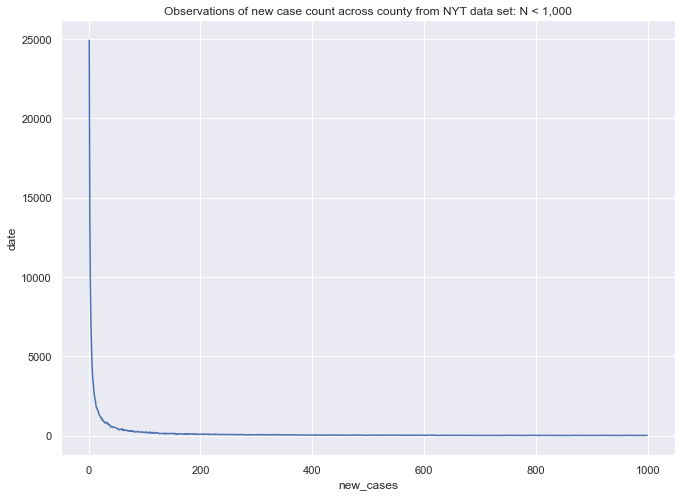

In [434]:
ax = sb.lineplot(x="new_cases", y="date", data=new_counts.loc[((new_counts['new_cases'] < 1000) ), :])
ax.set_title('Observations of new case count across county from NYT data set: N < 1,000')

Text(0.5, 1.0, 'Observations of new case count across county from NYT data set: N > 100')

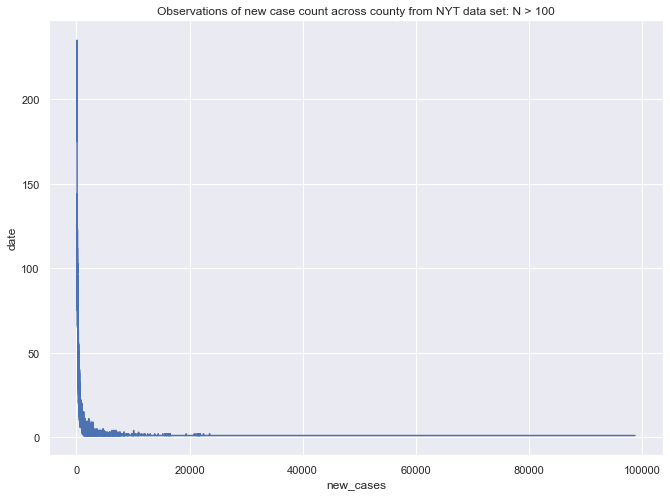

In [445]:
ax = sb.lineplot(x="new_cases", y="date", data=new_counts.loc[((new_counts['new_cases'] > 100) ), :])
ax.set_title('Observations of new case count across county from NYT data set: N > 100')

Text(0.5, 1.0, 'Observations of new case count across county from NYT data set: N >= 100')

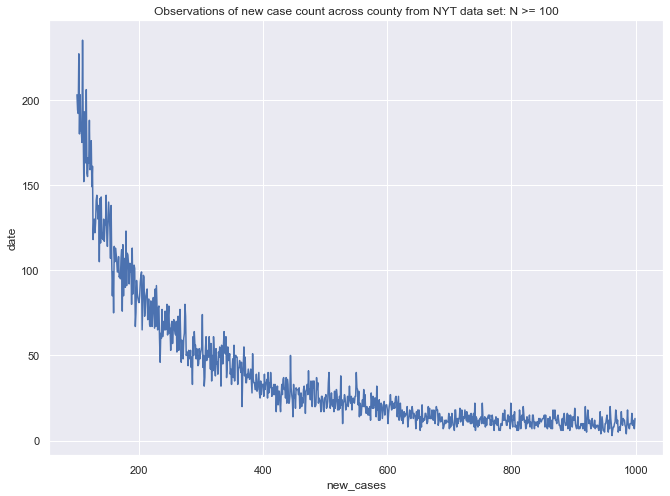

In [430]:
ax = sb.lineplot(x="new_cases", y="date", data=new_counts.loc[((new_counts['new_cases'] > 99) & (new_counts['new_cases'] < 1000) ), :])
ax.set_title('Observations of new case count across county from NYT data set: N: 100-1,000')

Text(0.5, 1.0, 'Observations of new case count across county from NYT data set: N: 200-1,000')

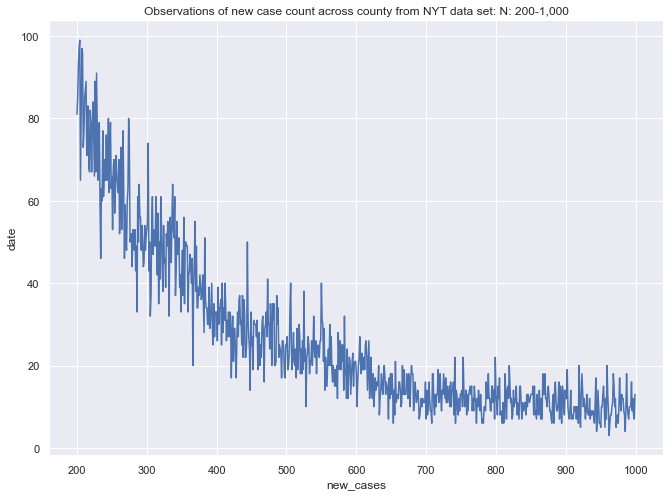

In [435]:
ax = sb.lineplot(x="new_cases", y="date", data=new_counts.loc[((new_counts['new_cases'] > 199) & (new_counts['new_cases'] < 1000) ), :])
ax.set_title('Observations of new case count across county from NYT data set: N: 200-1,000')

Text(0.5, 1.0, 'Observations of new case count across county from NYT data set: N 1,000-3,000')

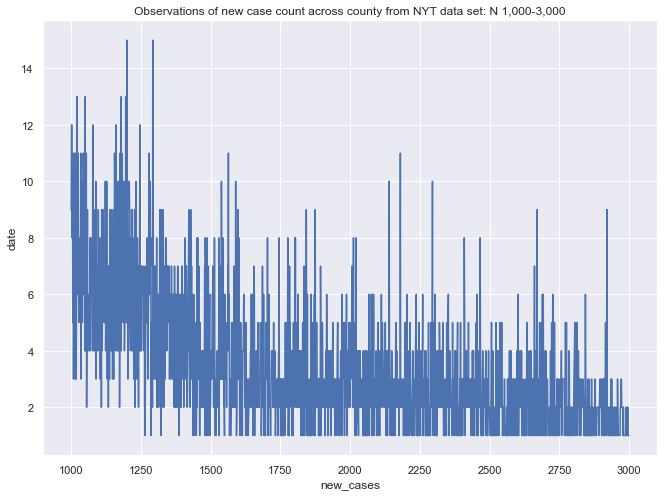

In [432]:
ax = sb.lineplot(x="new_cases", y="date", data=new_counts.loc[((new_counts['new_cases'] > 999) & (new_counts['new_cases'] < 3000) ), :])
ax.set_title('Observations of new case count across county from NYT data set: N 1,000-3,000')

In [441]:
new_counts.loc[((new_counts['new_cases'] > 199) & (new_counts['new_cases'] < 1000) ), :].sort_values('date').head(25)

,new_cases,date
7358,962.0,3
7340,944.0,4
7381,985.0,4
7352,956.0,5
7368,972.0,5
7317,921.0,5
7346,950.0,5
7290,894.0,6
7178,782.0,6
7176,780.0,6
